In [1]:
import os
import sys
import time
import h5py
import pygrib
import numpy as np
import netCDF4 as nc
from datetime import datetime, timedelta

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [4]:
import graph_utils as gu

In [5]:
from scipy.spatial import cKDTree

**Batch gen 2021**

In [6]:
with h5py.File(save_dir+'MRMS_ERA5_domain.hdf', 'r') as h5io:
    lon_ERA5 = h5io['lon_ERA5'][...]
    lat_ERA5 = h5io['lat_ERA5'][...]
    lon_MRMS = h5io['lon_MRMS'][...]
    lat_MRMS = h5io['lat_MRMS'][...]
    indx = h5io['MRMR_to_ERA5_indx'][...]
    indy = h5io['MRMR_to_ERA5_indy'][...]

In [7]:
base = datetime(2021, 1, 1)
date_list = [base + timedelta(hours=day) for day in range(365*24)]

**Single Profile batches**

In [8]:
def rain_context(data, bin_width, output_size, thres):
    output = np.zeros(output_size)

    for i in range(output_size[0]):
        for j in range(output_size[1]):

            i0 = i*bin_width; i1 = i0 + bin_width
            j0 = j*bin_width; j1 = j0 + bin_width
            patch_mean = np.mean(data[i0:i1, j0:j1])
            output[i, j] = patch_mean # >= thres
            
    return output


def is_unique(x1, x2):
    arr = np.vstack([x1, x2])
    _, ind = np.unique(arr, axis=1, return_index=True)
    out = np.zeros(shape=arr.shape[1], dtype=bool)
    out[ind] = True
    return out


def norm_precip(x):
    return np.log(x+1)

def norm_wind(x):
    return x/5

def norm_rh(x):
    return x/100 - 0.5
    
def norm_gph(x):
    # 600 hPa to 1000 hPa
    return x/40000 - 0.5

def norm_t(x):
    return (x-273.15)/10

In [16]:
size_mrms = 400
size_half = 200

x_mrms = 3500
y_mrms = 7000

gap = size_half

x_ERA5 = 361
y_ERA5 = 721
L = 12

rain_thres = 1.0
rain_cover_thres = 0.4

profile_t = np.zeros(L)
profile_u = np.zeros(L)
profile_v = np.zeros(L)
profile_rh = np.zeros(L)
profile_gph = np.zeros(L)

nc_name_t = ERA5_dir+'ERA5_t2m_2021_bottom_layers.nc'
nc_name_u = ERA5_dir+'ERA5_u_2021_bottom_layers.nc'
nc_name_v = ERA5_dir+'ERA5_v_2021_bottom_layers.nc'
nc_name_rh = ERA5_dir+'ERA5_rh_2021_bottom_layers.nc'
nc_name_gph = ERA5_dir+'ERA5_gph_2021_bottom_layers.nc'

batch_file_name = 'DSCALE_dt{:04d}_i{:04d}_j{:04d}.npy'

with nc.Dataset(nc_name_t) as ncio_t:
    with nc.Dataset(nc_name_u) as ncio_u:
        with nc.Dataset(nc_name_v) as ncio_v:
            with nc.Dataset(nc_name_rh) as ncio_rh:
                with nc.Dataset(nc_name_gph) as ncio_gph:
                    
                    # Main section
                    for i_dt, dt in enumerate(date_list[:1]):
                        dt_str = datetime.strftime(dt, '%Y%m%d-%H%M%S')
                        name_ = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str)
                        filename = MRMS_dir + name_
                    
                        if os.path.isfile(filename):
                            with pygrib.open(filename) as grbio:
                                MRMS = grbio[1].values
                                
                            # flip --> lower latitude at the bottom
                            MRMS = np.flipud(MRMS)
                    
                            for i_mrms in range(0, x_mrms-size_mrms+gap, gap):
                                for j_mrms in range(0, y_mrms-size_mrms+gap, gap):
                                    i0 = i_mrms; i1 = i0 + size_mrms
                                    j0 = j_mrms; j1 = j0 + size_mrms
                                    patch_ = MRMS[i0:i1, j0:j1]
                                    patch_flag = patch_ > rain_thres
                                    patch_rain_cover_rate = np.sum(patch_flag)/(size_mrms*size_mrms)
                                    
                                    # We select this patch
                                    if (patch_.shape == (size_mrms, size_mrms)) and (patch_rain_cover_rate > rain_cover_thres):
                                        patch = patch_
                                        ix_era5 = indx[i0:i1, j0:j1]
                                        iy_era5 = indy[i0:i1, j0:j1]
                                        context = rain_context(patch, bin_width=16, output_size=(25, 25), thres=rain_thres)
                                        
                                        ix_era5_rain_ = ix_era5[patch_flag]
                                        iy_era5_rain_ = iy_era5[patch_flag]
                                        
                                        flag_uniqe_ind = is_unique(ix_era5_rain_, iy_era5_rain_)
                                        N_points = np.sum(flag_uniqe_ind)
                                        ix_era5_rain = ix_era5_rain_[flag_uniqe_ind]
                                        iy_era5_rain = iy_era5_rain_[flag_uniqe_ind]
                                        
                                        # Get the mean ERA5 profiles
                                        profile_t[...] = 0.0
                                        profile_u[...] = 0.0
                                        profile_v[...] = 0.0
                                        profile_rh[...] = 0.0
                                        profile_gph[...] = 0.0

                                        for i_point in range(N_points):
                                            ix_era5_rain_temp = ix_era5_rain[i_point]
                                            iy_era5_rain_temp = iy_era5_rain[i_point]

                                            # ERA5 levels: top to bottom (600 --> 1000 hPa)
                                            profile_t += ncio_t['t'][i_dt, :, ix_era5_rain_temp, iy_era5_rain_temp]
                                            profile_u += ncio_u['u'][i_dt, :, ix_era5_rain_temp, iy_era5_rain_temp]
                                            profile_v += ncio_v['v'][i_dt, :, ix_era5_rain_temp, iy_era5_rain_temp]
                                            profile_rh += ncio_rh['r'][i_dt, :, ix_era5_rain_temp, iy_era5_rain_temp]
                                            profile_gph += ncio_gph['z'][i_dt, :, ix_era5_rain_temp, iy_era5_rain_temp]

                                        profile_t = norm_t(profile_t/N_points)
                                        profile_u = norm_wind(profile_u/N_points)
                                        profile_v = norm_wind(profile_v/N_points)
                                        profile_rh = norm_rh(profile_rh/N_points)
                                        profile_gph = norm_gph(profile_gph/N_points)

                                        patch = norm_precip(patch)
                                        context = norm_precip(context)

                                        save_dict = {}
                                        save_dict['patch'] = patch
                                        save_dict['context'] = context
                                        save_dict['profile_t'] = profile_t
                                        save_dict['profile_u'] = profile_u
                                        save_dict['profile_v'] = profile_v
                                        save_dict['profile_rh'] = profile_rh
                                        save_dict['profile_gph'] = profile_gph
                                        
                                        name_ = BATCH_dir+batch_file_name.format(i_dt, i_mrms, j_mrms)
                                        print(name_)
                                        np.save(name_, save_dict)

/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1000_j2800.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1000_j3000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1000_j3200.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1000_j3400.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1000_j3600.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1000_j3800.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1200_j2800.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1200_j3000.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1200_j3200.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1200_j3400.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1200_j3600.npy
/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1400_j3200.npy


In [12]:
cmap_pct, A = gu.precip_cmap()

In [17]:
temp_data = np.load('/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/DSCALE_dt0000_i1200_j2800.npy', allow_pickle=True)[()]

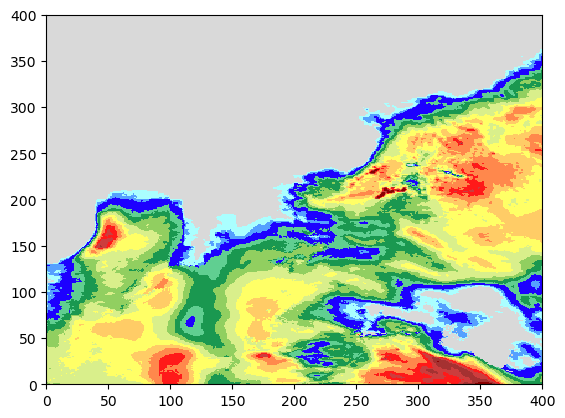

In [20]:
plt.pcolormesh(temp_data['patch'], cmap=cmap_pct, vmin=0, vmax=2)

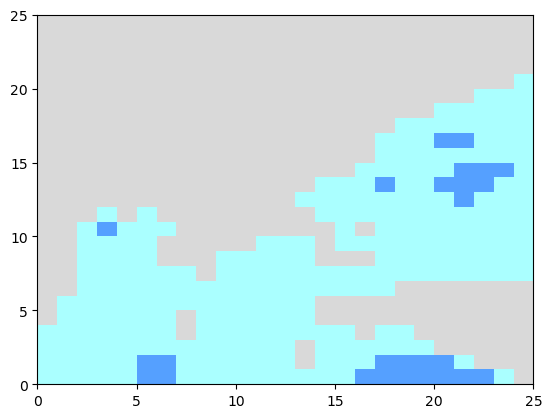

In [21]:
plt.pcolormesh(temp_data['context'], cmap=cmap_pct, vmin=0, vmax=10)

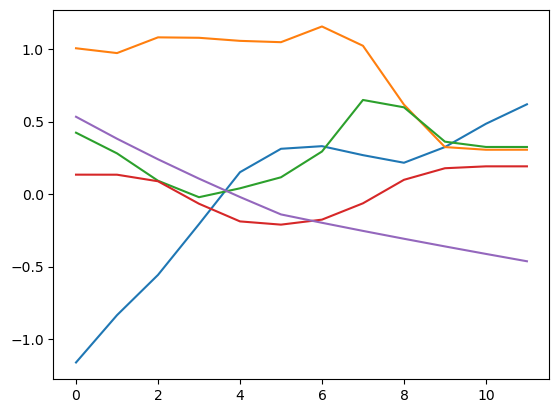

In [22]:
plt.plot(temp_data['profile_t'])
plt.plot(temp_data['profile_u'])
plt.plot(temp_data['profile_v'])
plt.plot(temp_data['profile_rh'])
plt.plot(temp_data['profile_gph'])

In [80]:
profile_v

array([ 4.91816304,  5.10289934,  3.17988085, -0.2157098 , -1.62072386,
       -0.71993227,  0.48334227,  1.3194054 ,  1.53981562,  1.28027021,
        0.50965557,  0.41874014])

In [81]:
profile_u

array([-1.19389826, -1.78142319, -0.99990405, -1.03627556, -2.91077454,
       -3.55603203, -3.65380532, -3.31660872, -3.32381888, -4.78386229,
       -3.91969579, -2.3287791 ])

In [53]:
check_map = np.arange(size_mrms*size_mrms).reshape(size_mrms, size_mrms)

In [25]:
check_map[ix_era5_rain, iy_era5_rain]

0.04815

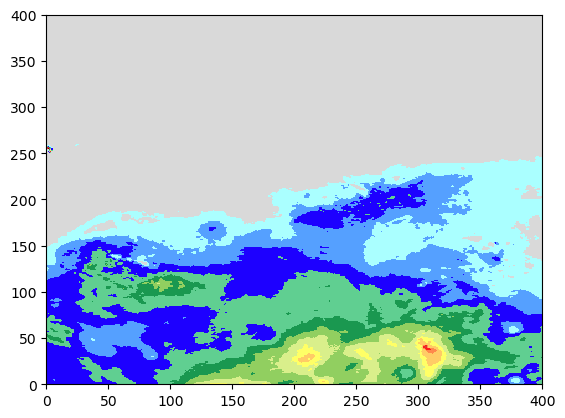

In [32]:
plt.pcolormesh(patch, cmap=cmap_pct, vmin=0, vmax=10)

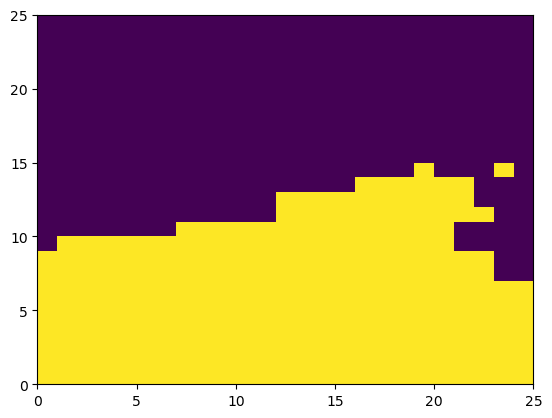

In [33]:
plt.pcolormesh(context)

In [6]:
patch_

'/glade/campaign/cisl/aiml/ksha/MRMS/MRMS_MultiSensor_QPE_01H_Pass2_00.00_20210101-000000.grib2'

True

In [ ]:
with pygrib.open('/glade/scratch/ksha/MRMS/MRMS_MultiSensor_QPE_01H_Pass2_00.00_20210101-210000.grib2') as grbio:
    MRMS = grbio[1].values